In [2]:
#FeatureSelectionByMultilevelEnrichmentImports
import numpy as np
import os
import sys
import collections
import matplotlib.pyplot as plt
import loompy
from collections import Counter
from tqdm import tqdm
import warnings

import chromograph
from chromograph.peak_calling.utils import *
from chromograph.pipeline.utils import *
from chromograph.plotting.marker_plot import marker_plot
from chromograph.plotting.peak_annotation_plot import plot_peak_annotation_wheel
from chromograph.pipeline import config
from chromograph.preprocessing.utils import *

import cytograph as cg
from cytograph.plotting.colors import colorize
from cytograph.enrichment import FeatureSelectionByMultilevelEnrichment
from cytograph.species import Species

from typing import *

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import loompy
import scipy.stats as stats
from statsmodels.sandbox.stats.multicomp import multipletests
from scipy.spatial.distance import jaccard

import logging
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

config = config.load_config()

['Age', 'Agetext', 'Ageunit', 'All_fc_analysis_id', 'Analysis', 'BpLength', 'CDNAConc', 'CellConc', 'CellCycle', 'CellCycle_G1', 'CellCycle_G2M', 'CellCycle_S', 'CellID', 'Cellconc', 'Chemistry', 'Clusters', 'ClustersModularity', 'ClustersSurprise', 'Cmobarcodes', 'Comment', 'CreationDate', 'Datecaptured', 'Donor', 'DoubletFinderFlag', 'DoubletFinderScore', 'Editat', 'Editby', 'FinalConc', 'Id', 'IsCycling', 'Label', 'MT_ratio', 'MeanTotalUMI', 'Method', 'NGenes', 'Name', 'Neuronprop', 'Numpooledanimals', 'Outliers', 'OutliersModularity', 'OutliersSurprise', 'PCA', 'PCRCycles', 'Plugdate', 'Project', 'RegionOfInterest', 'Roi', 'SampleID', 'SampleName', 'Sampleok', 'Sex', 'Shortname', 'Species', 'Strain', 'Subset', 'TSNE', 'TargetNumCells', 'Targetnumcells', 'Tissue', 'TotalUMI', 'Transcriptome', 'UMAP', 'UMAP3D', '_X', '_Y', 'passedQC', 'unspliced_ratio', 'velocyto.__version__', 'velocyto.logic']


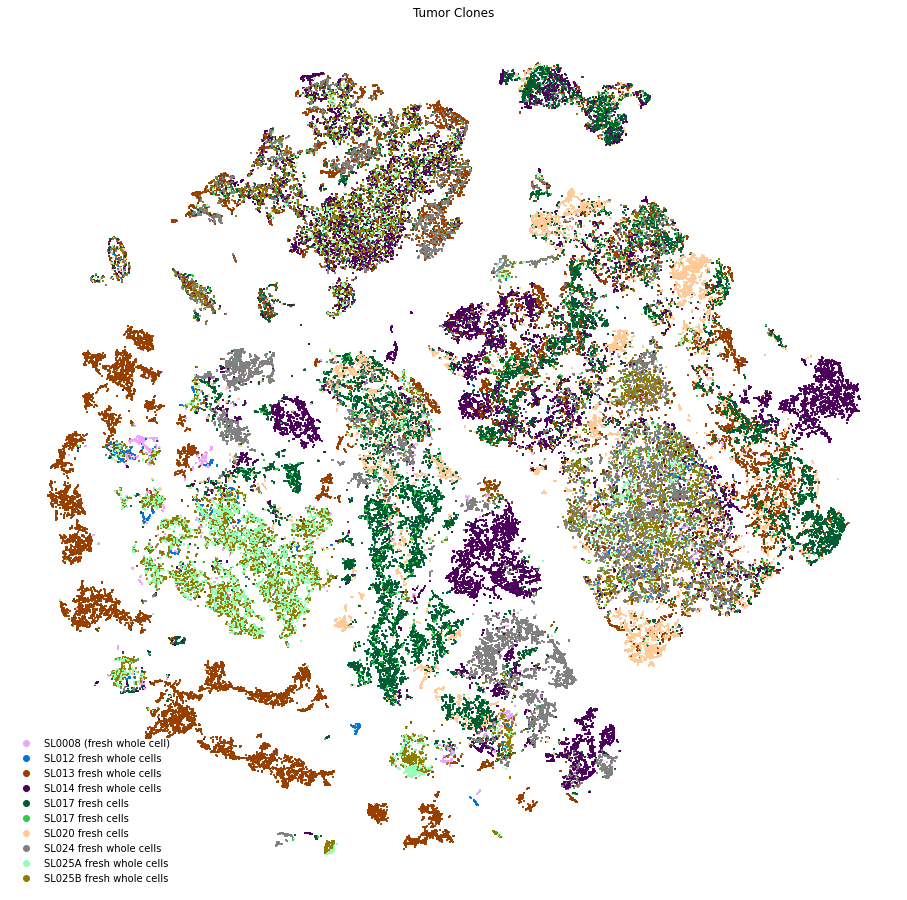

In [8]:
f = '/proj/GBM/FRESH_20210607/data/GBM.loom'
def h(c):
    return plt.Line2D([], [], color=c, ls="", marker="o")
    
with loompy.connect(f, 'r') as ds:
    print(ds.ca.keys())
    fig, ax = plt.subplots(figsize=(16,16))
    names, labels = np.unique(ds.ca.SampleName, return_inverse=True)
    colors = colorize(names)
    ax.scatter(ds.ca.TSNE[:,0],ds.ca.TSNE[:,1], c=colors[labels], marker=',', s=1)
    ax.legend(handles=[h(colors[i]) for i in range(len(names))], labels=list(names), loc='lower left', markerscale=1, frameon=False, fontsize=10)
    ax.set_title(f'Tumor Clones')
    ax.axis('off')  

100%|██████████| 44/44 [06:27<00:00,  8.82s/it]


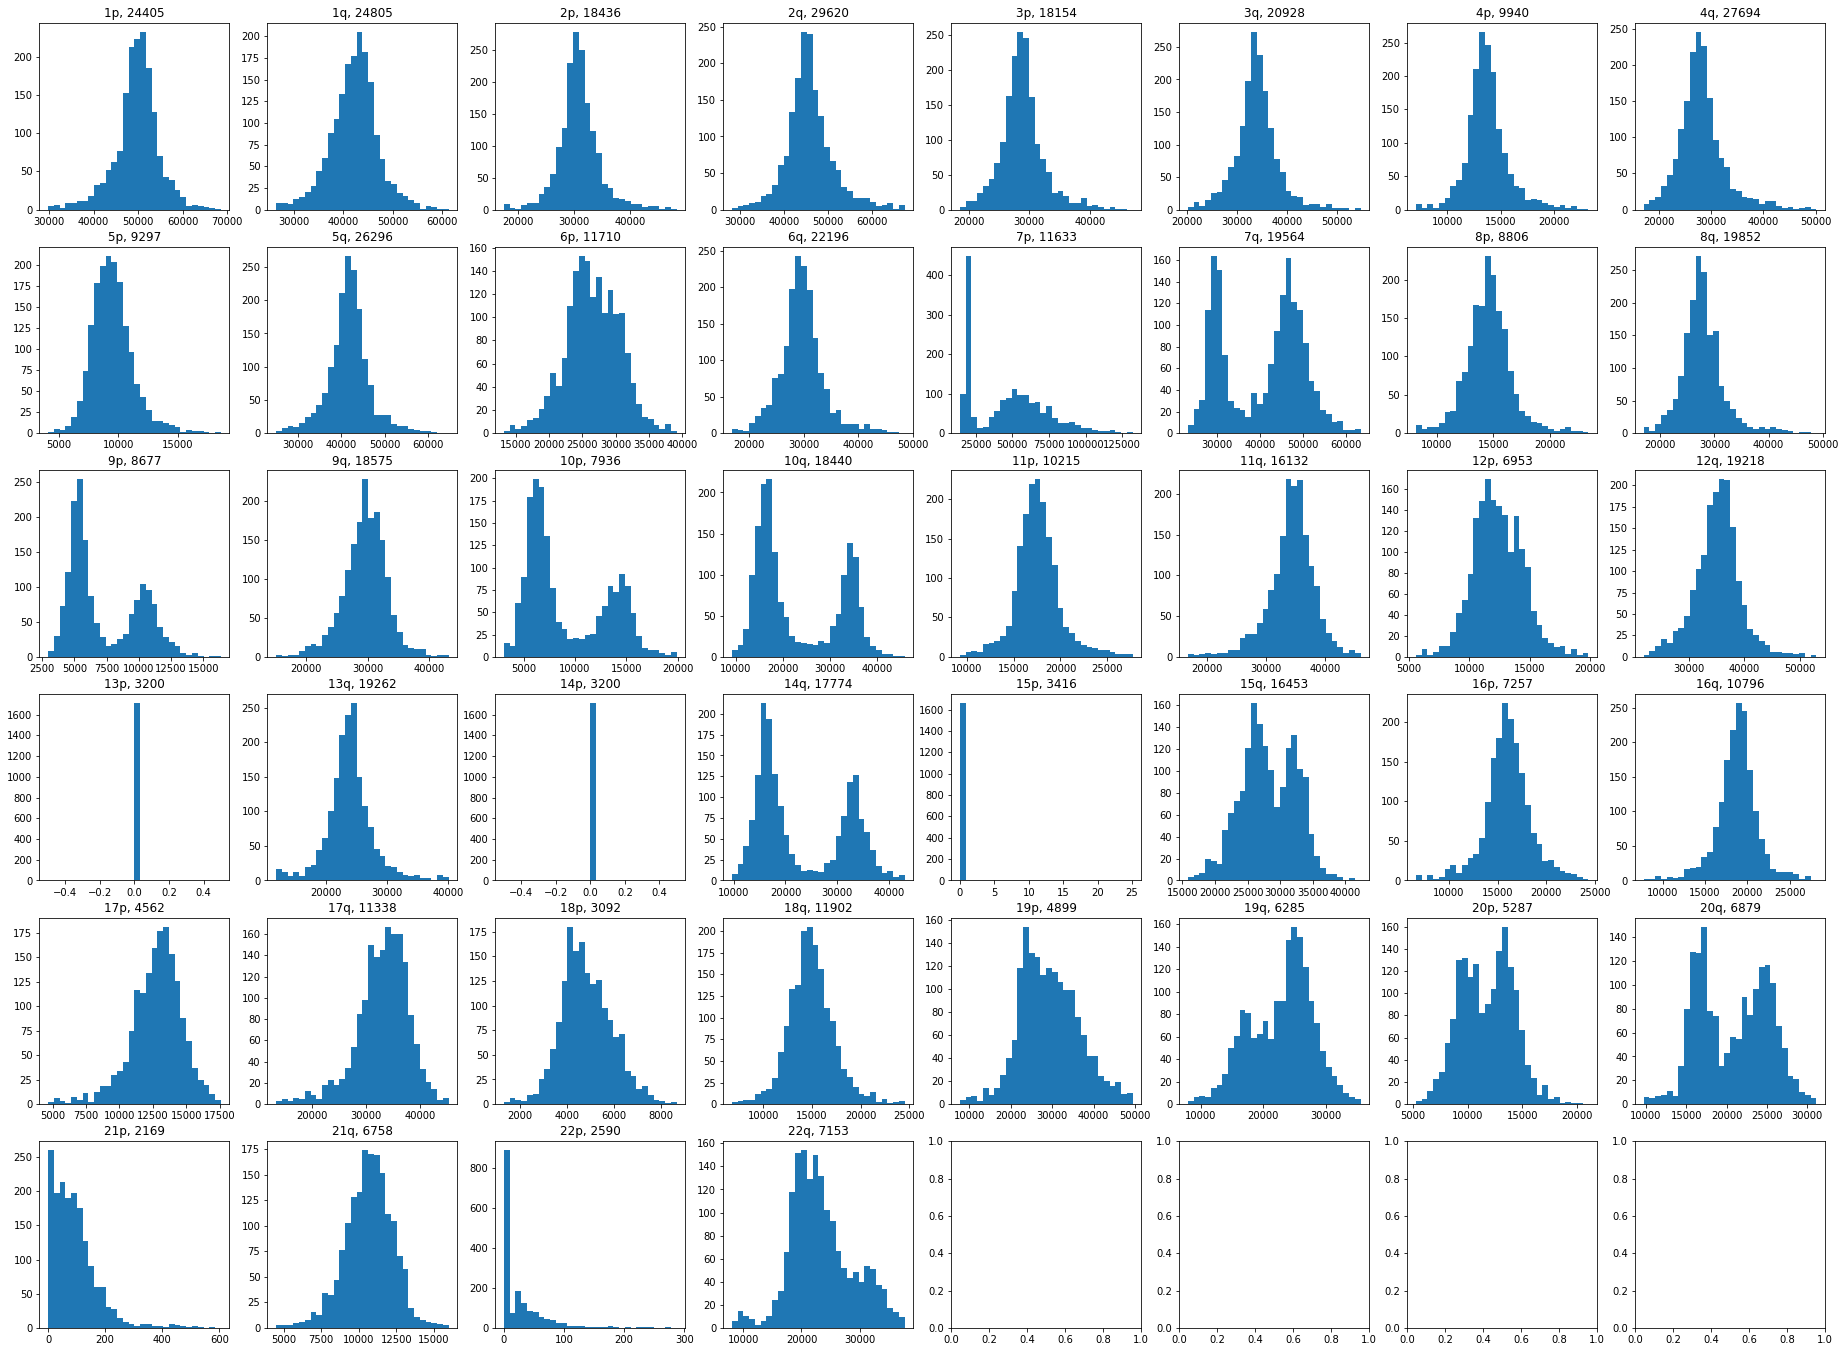

In [26]:
with loompy.connect(f_bins, 'r') as ds:
    mu = ds[''].map([np.sum], axis=1)[0]
    arms = np.loadtxt("/home/camiel/chromograph/chromograph/references/chromosome_arm_positions_grch38.txt", dtype=str, skiprows=1)
    cnt = Counter(ds.ra.chrom)
    
    fig, ax = plt.subplots(6,8, figsize=(32,24))
    ax = ax.flatten()
    
    X = np.zeros((len(arms), ds.shape[1]))
    
    for i in tqdm(range(len(arms))):
        Valid = (ds.ra.chrom == f'chr{arms[i,1]}') & (ds.ra.start.astype(int) >=int(arms[i,2])) & (ds.ra.end.astype(int) <= int(arms[i,3]))
        bins = ds[''].sparse(rows=Valid)

        a = np.array(bins.sum(axis=0)).flatten()/(1e-6*mu)
        X[i,:] = a
        ax[i].hist(a, bins=30, range=(np.quantile(a, .01), np.quantile(a, .99)))
        ax[i].set_title(f'{arms[i,0]}, {sum(Valid)}')

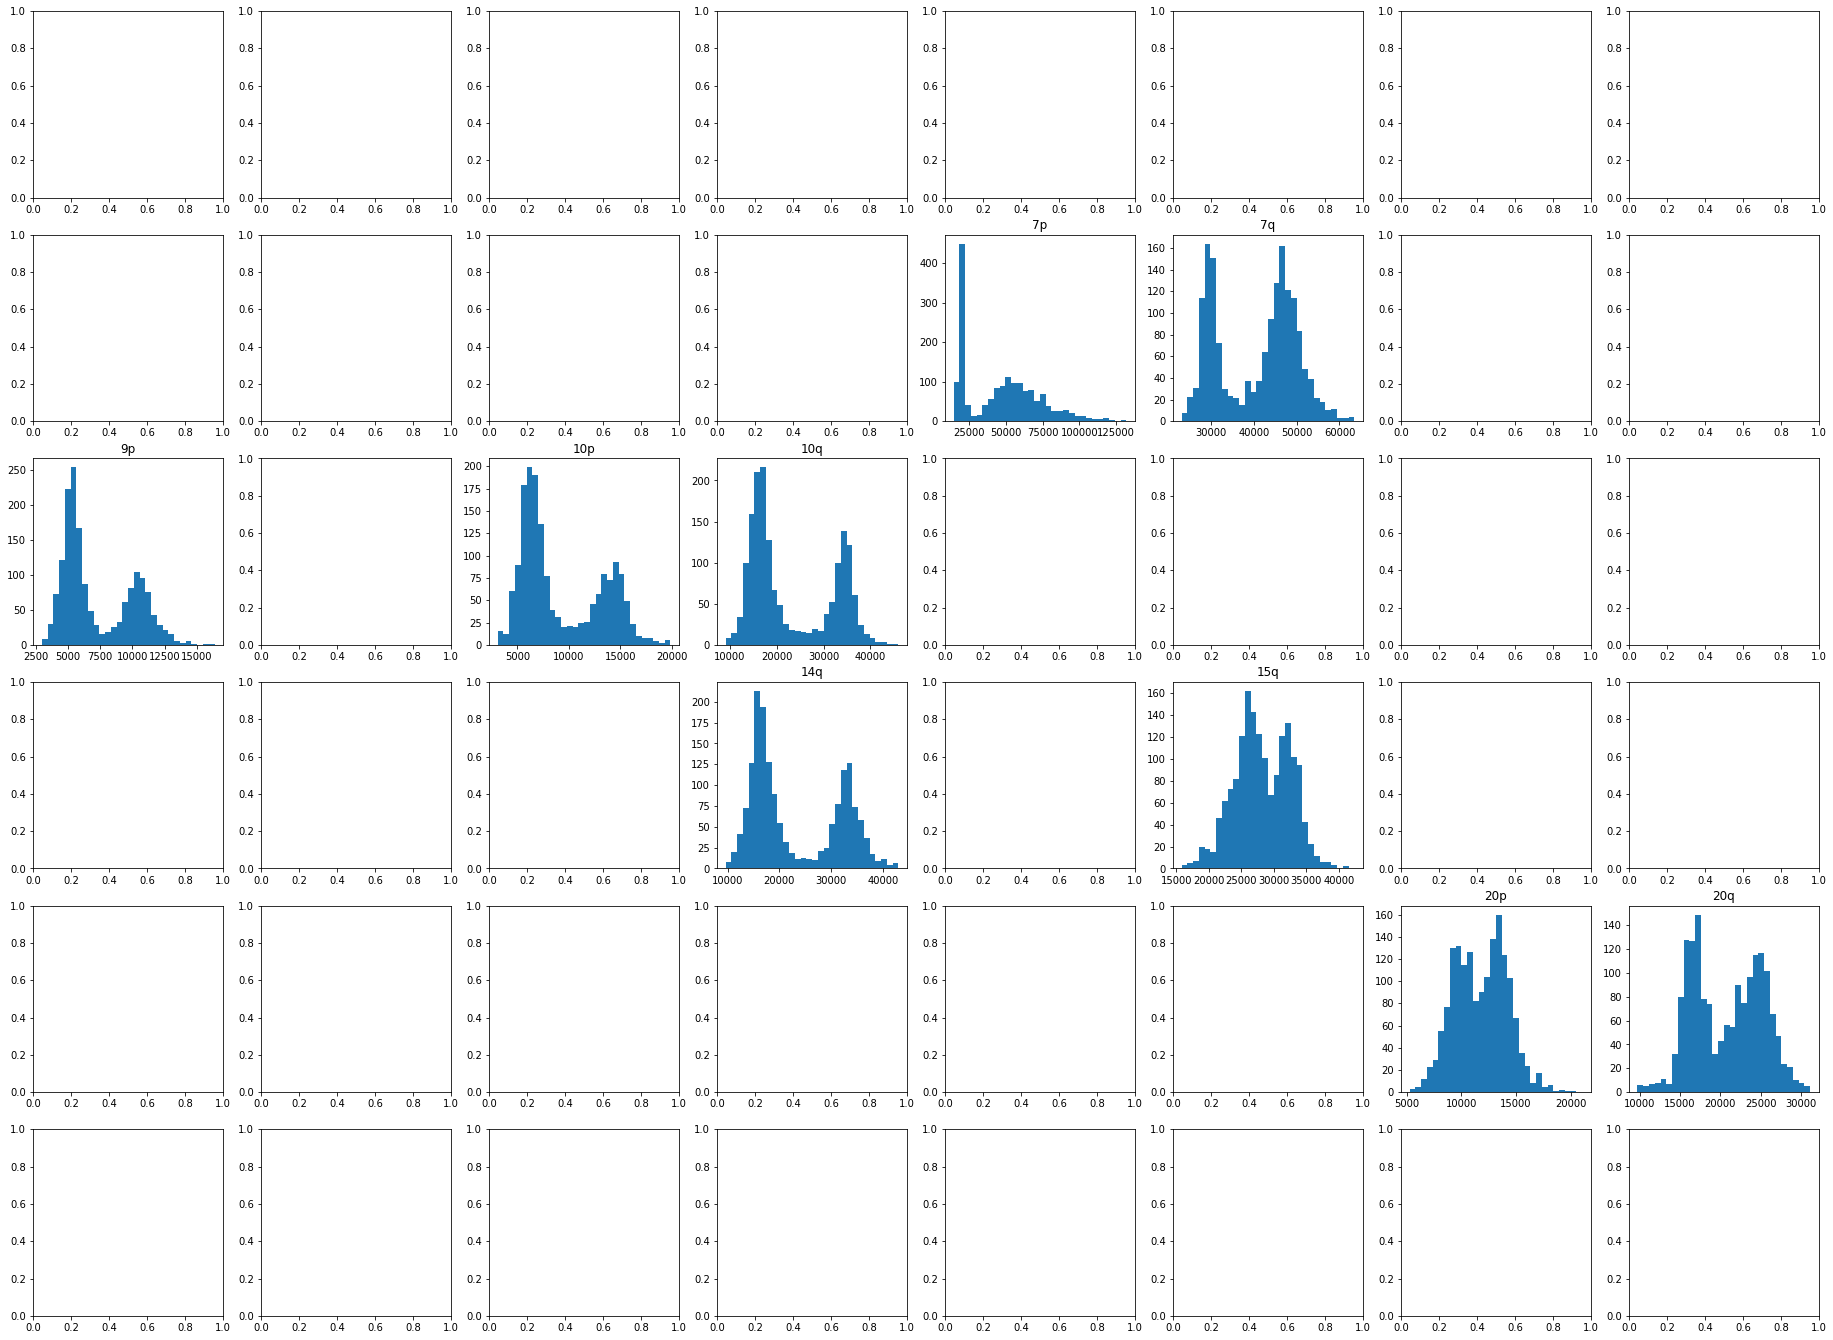

In [127]:
from unidip import UniDip
intervals = []

for i in range(X.shape[0]):
    intervals.append(UniDip(X[i,:]).run())
bimodals = np.where(np.array([len(x) for x in intervals]) >= 2)[0]
fig, ax = plt.subplots(6,8, figsize=(32,24))
ax = ax.flatten()
    
for i in bimodals:
    a = X[i,:]
    ax[i].hist(a, bins=30, range=(np.quantile(a, .01), np.quantile(a, .99)))
    ax[i].set_title(f'{arms[i,0]}')

In [27]:
total = np.sum(arms[:,-1].astype(int))
expected = (arms[:,-1].astype(int) / total) * 1e6

In [28]:
expected

array([43288.06595562, 43996.57306359, 32703.12466485, 52538.53363196,
       32200.91921915, 37120.33119207, 17635.01942934, 49121.51584163,
       16490.56050382, 46641.09692734, 20771.59811465, 39368.00588022,
       20635.29333159, 34700.26120407, 15620.67464848, 35212.30403558,
       15392.18131103, 32947.19300588, 14078.58362895, 32708.71399992,
       18119.70055714, 28614.14187153, 12334.21338116, 34087.30171459,
        5675.89243321, 34166.41762447,  5675.89243321, 31526.10420867,
        6060.31814451, 29183.28737361, 12881.13918334, 19157.51513973,
        8092.99925062, 20110.68301   ,  5484.6499778 , 21111.50993006,
        8690.84845022, 11148.4254449 ,  9378.07557322, 12205.23298254,
        3854.12961839, 11988.25638558,  4595.62394894, 12687.09177283])

In [29]:
theta = 100

residuals = div0((X-expected.reshape(expected.shape[0],1)), np.sqrt(expected + np.power(expected, 2)/theta).reshape(expected.shape[0],1))

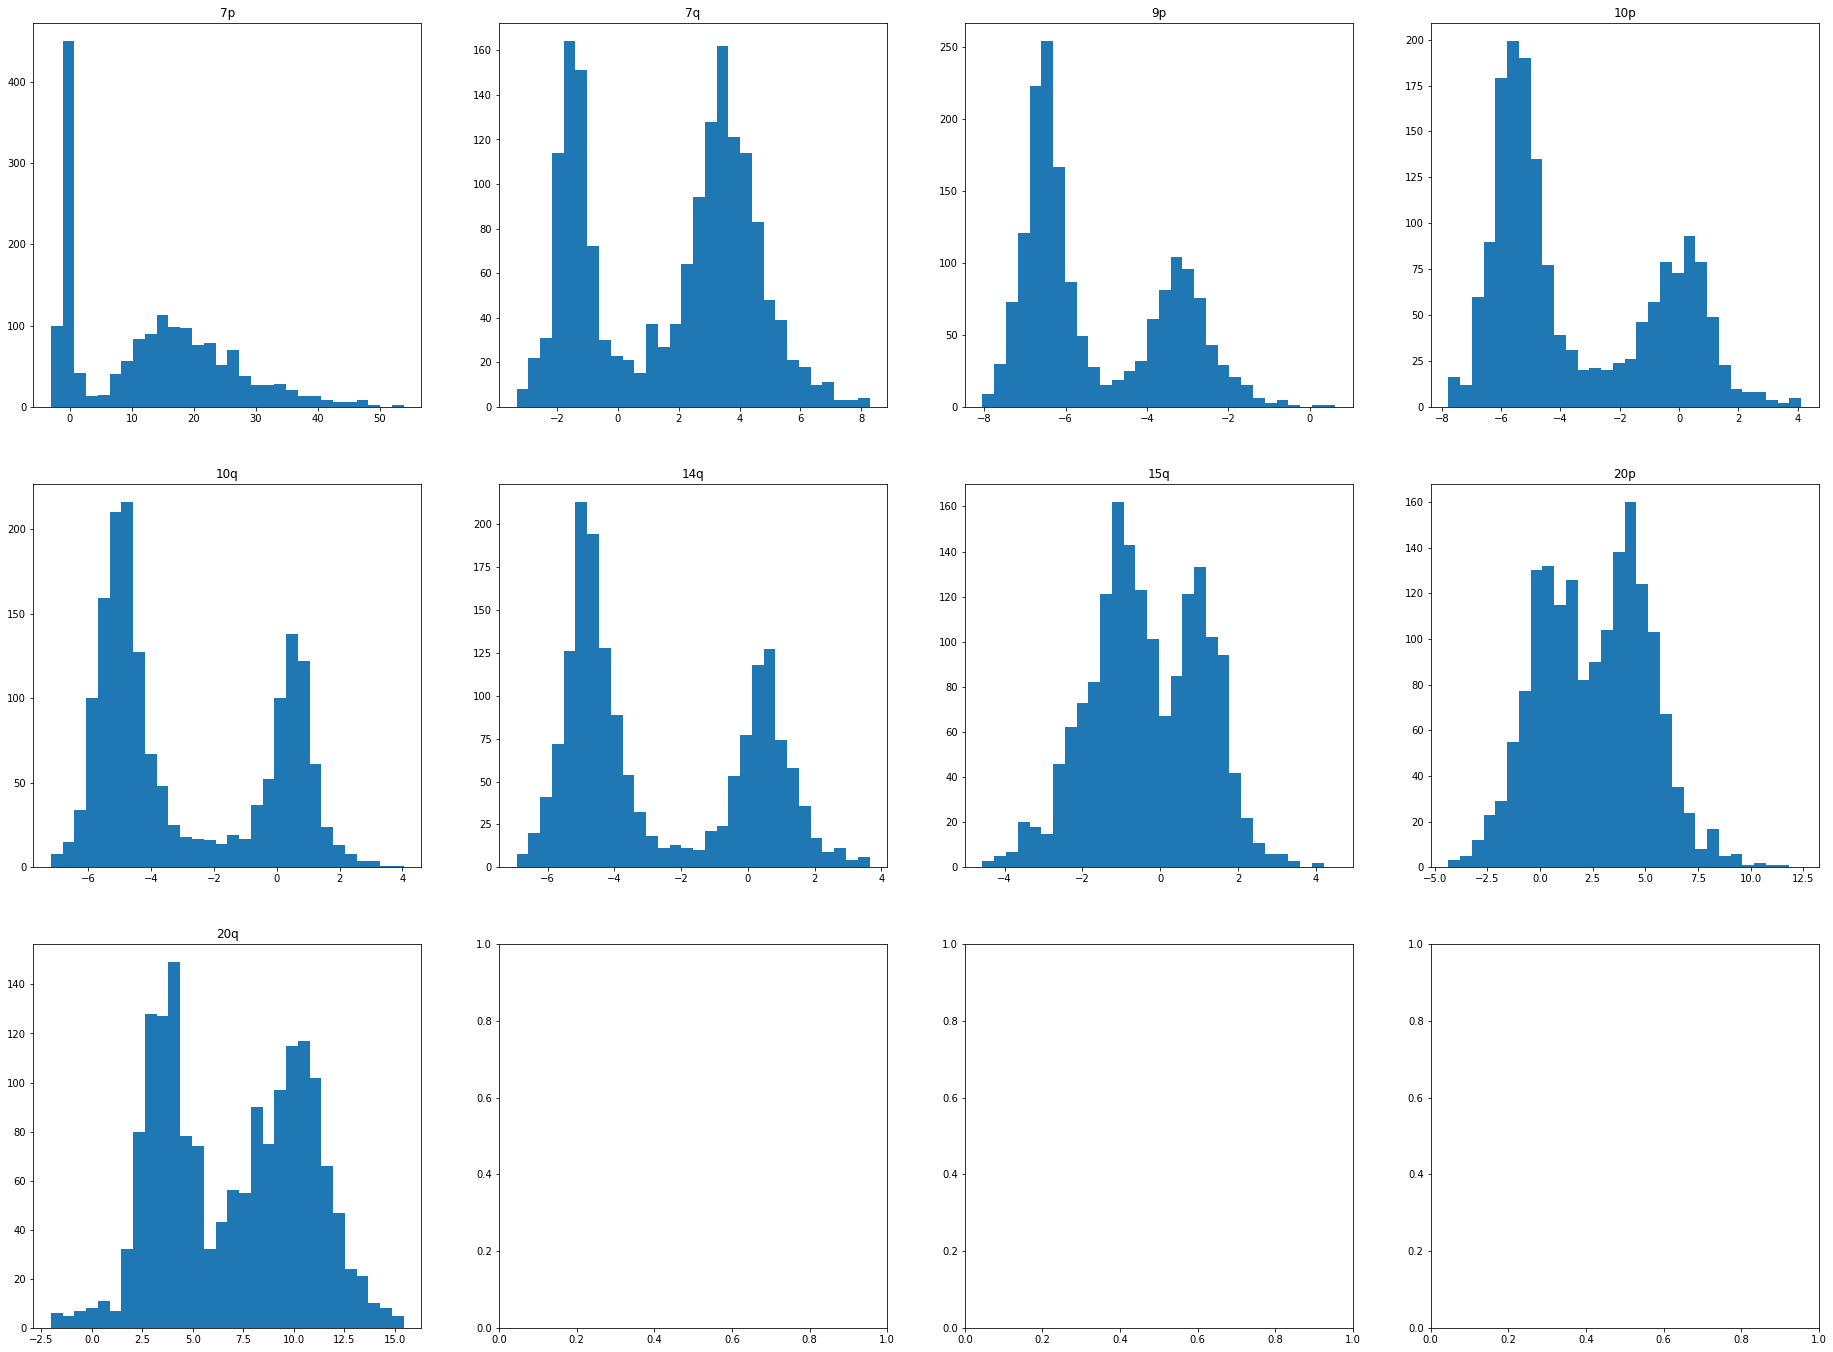

In [128]:
nrows = int(np.ceil(len(bimodals)/4))
fig, ax = plt.subplots(nrows, 4, figsize=(32,24))
ax = ax.flatten()

for i, x in enumerate(bimodals):
    a = residuals[x,:]
    ax[i].hist(a, bins=30, range=(np.quantile(a, .01), np.quantile(a, .99)))
    ax[i].set_title(arms[x,0])

In [49]:
mu = X.mean(1)
sd = X.std(1)

Z = div0(X.T - mu, sd).T

In [52]:
# plt.figure(figsize = (12,12))
# plt.imshow(X, cmap='coolwarm', aspect='auto')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43


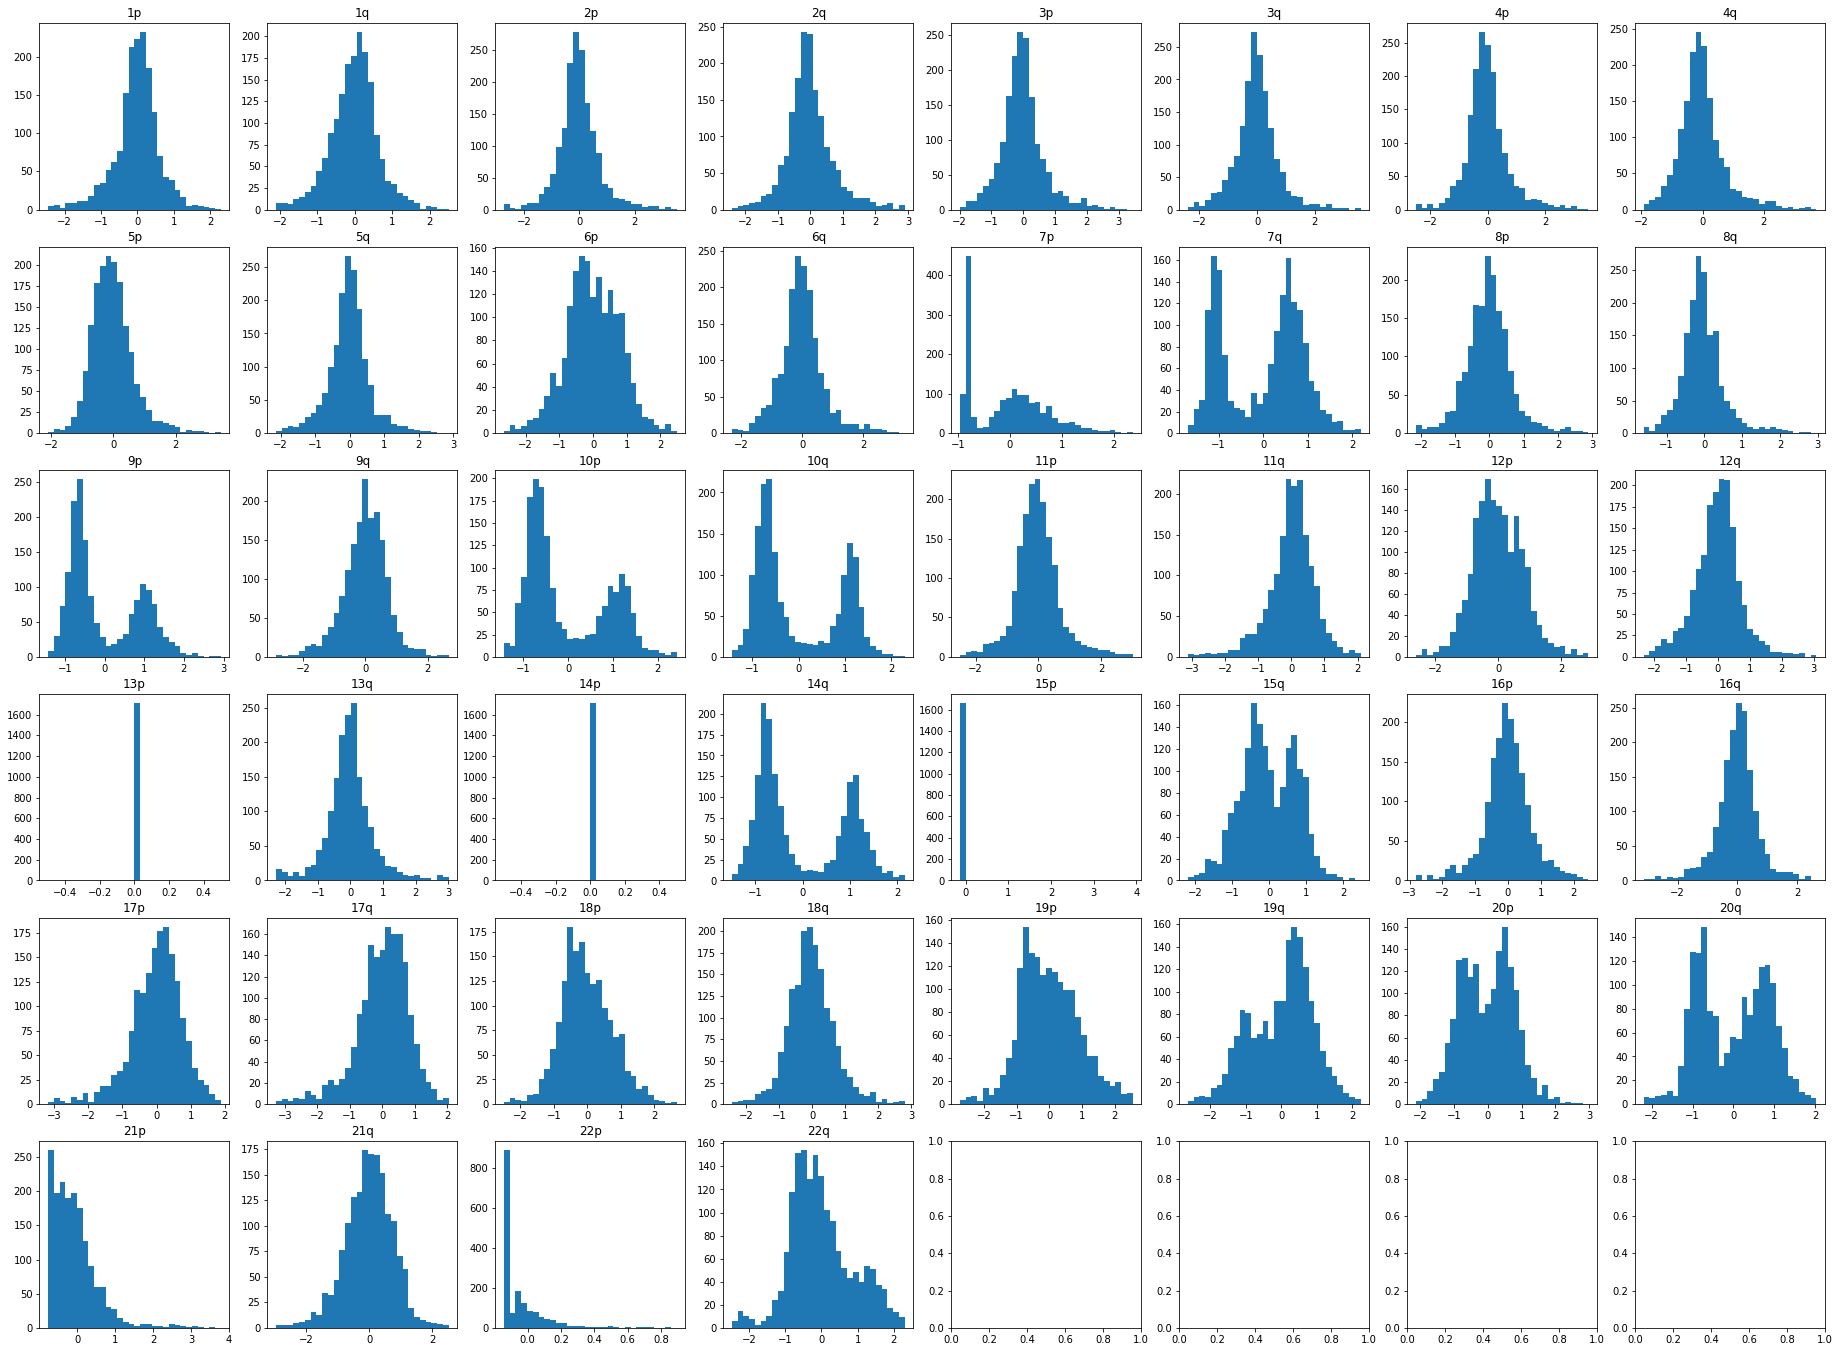

In [59]:
fig, ax = plt.subplots(6,8, figsize=(32,24))
ax = ax.flatten()
for i in range(len(arms)):
    print(i)
    a = Z[i,:].flatten()
    ax[i].hist(a, bins=30, range=(np.quantile(a, .01), np.quantile(a, .99)))
    ax[i].set_title(f'{arms[i,0]}')

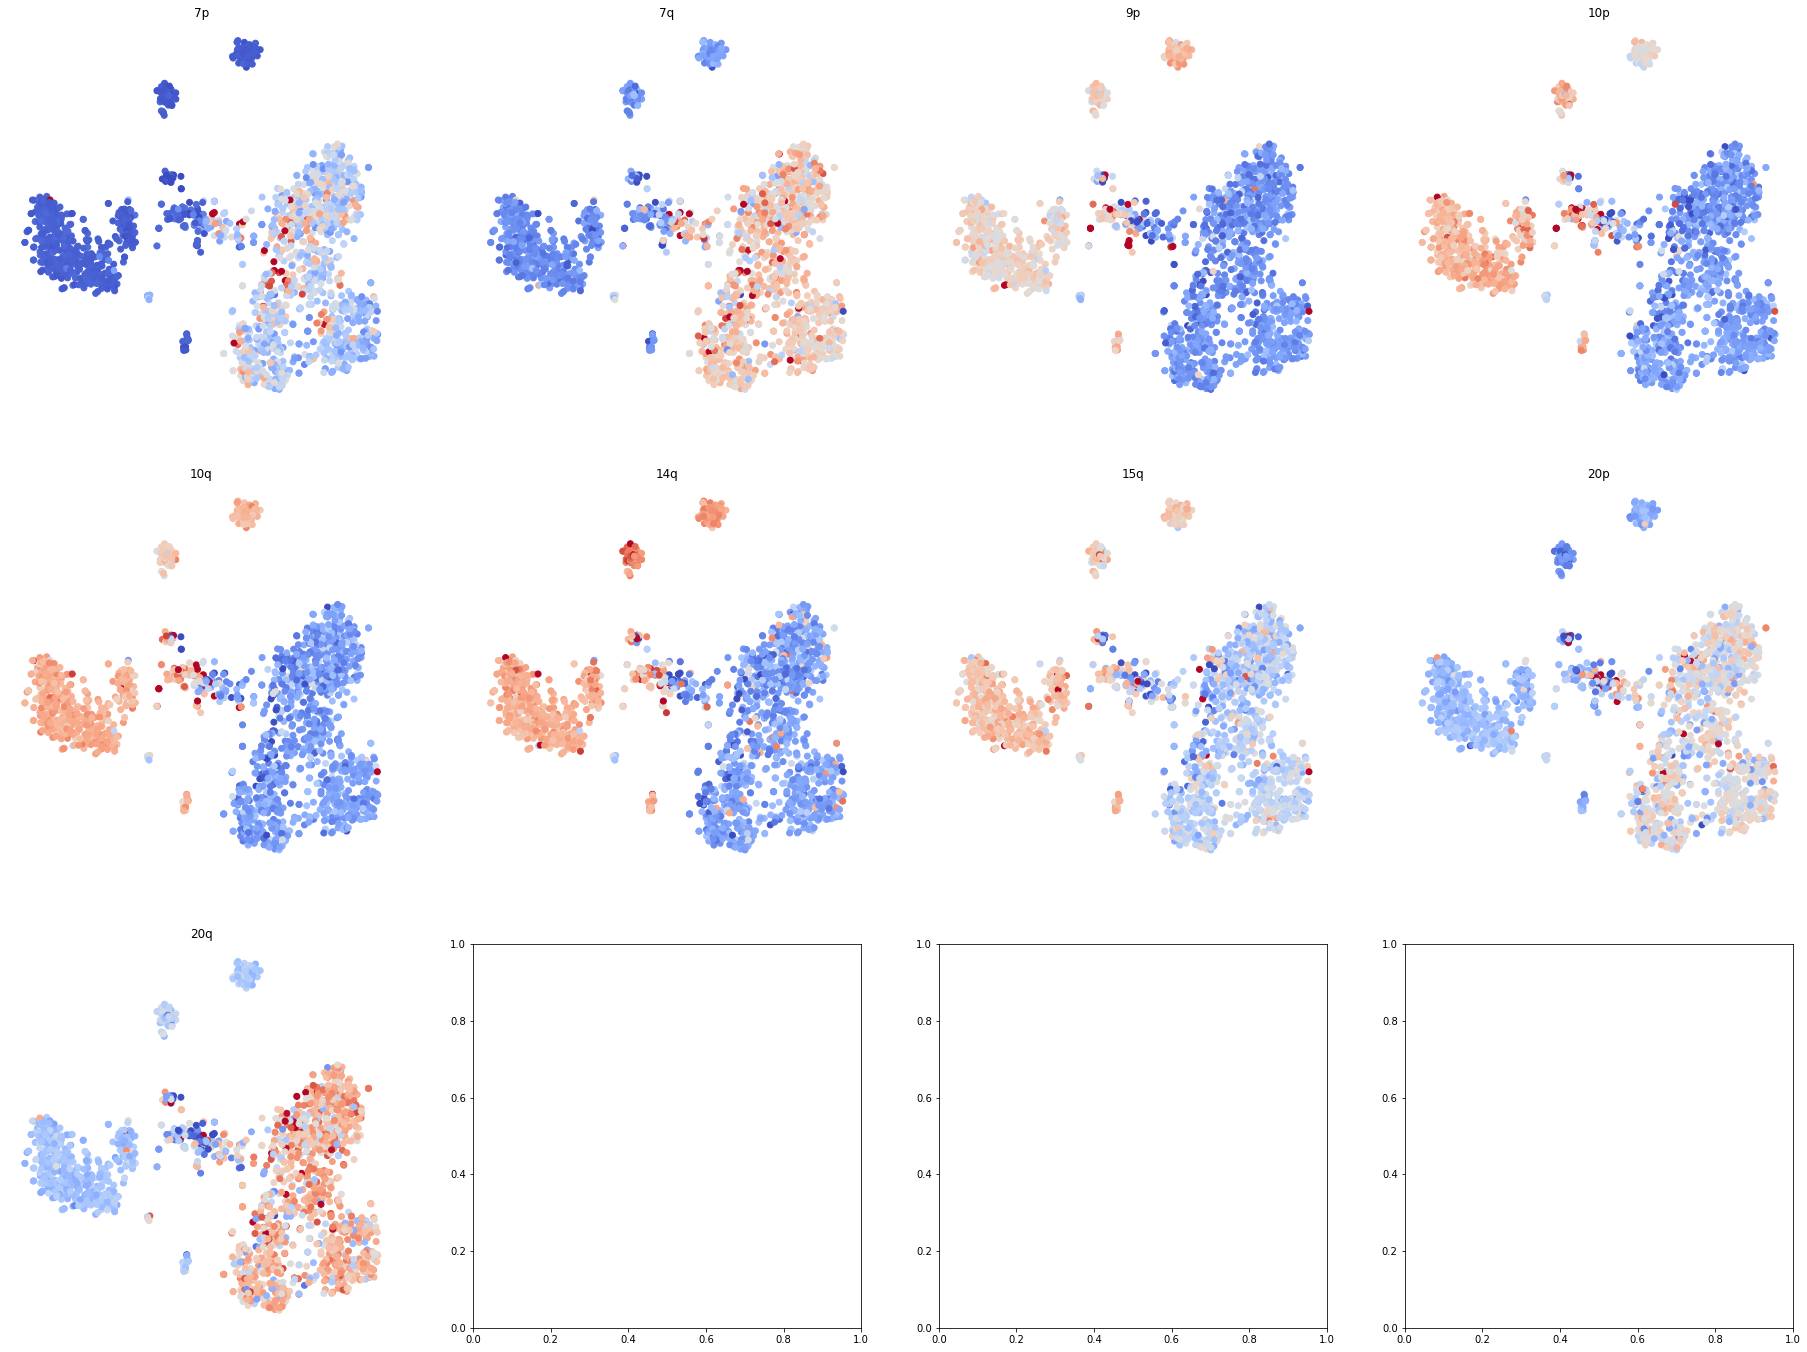

In [133]:
with loompy.connect(f_bins, 'r') as ds:
    nrows = int(np.ceil(len(bimodals)/4))
    fig, ax = plt.subplots(nrows, 4, figsize=(32,24))
    ax = ax.flatten()

    for i, x in enumerate(bimodals):
        ax[i].scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c=X[x,:], vmax=np.quantile(X[x,:], .99), vmin = np.quantile(X[x,:], .01), cmap='coolwarm')
        ax[i].set_title(arms[x,0])
        ax[i].axis('off')

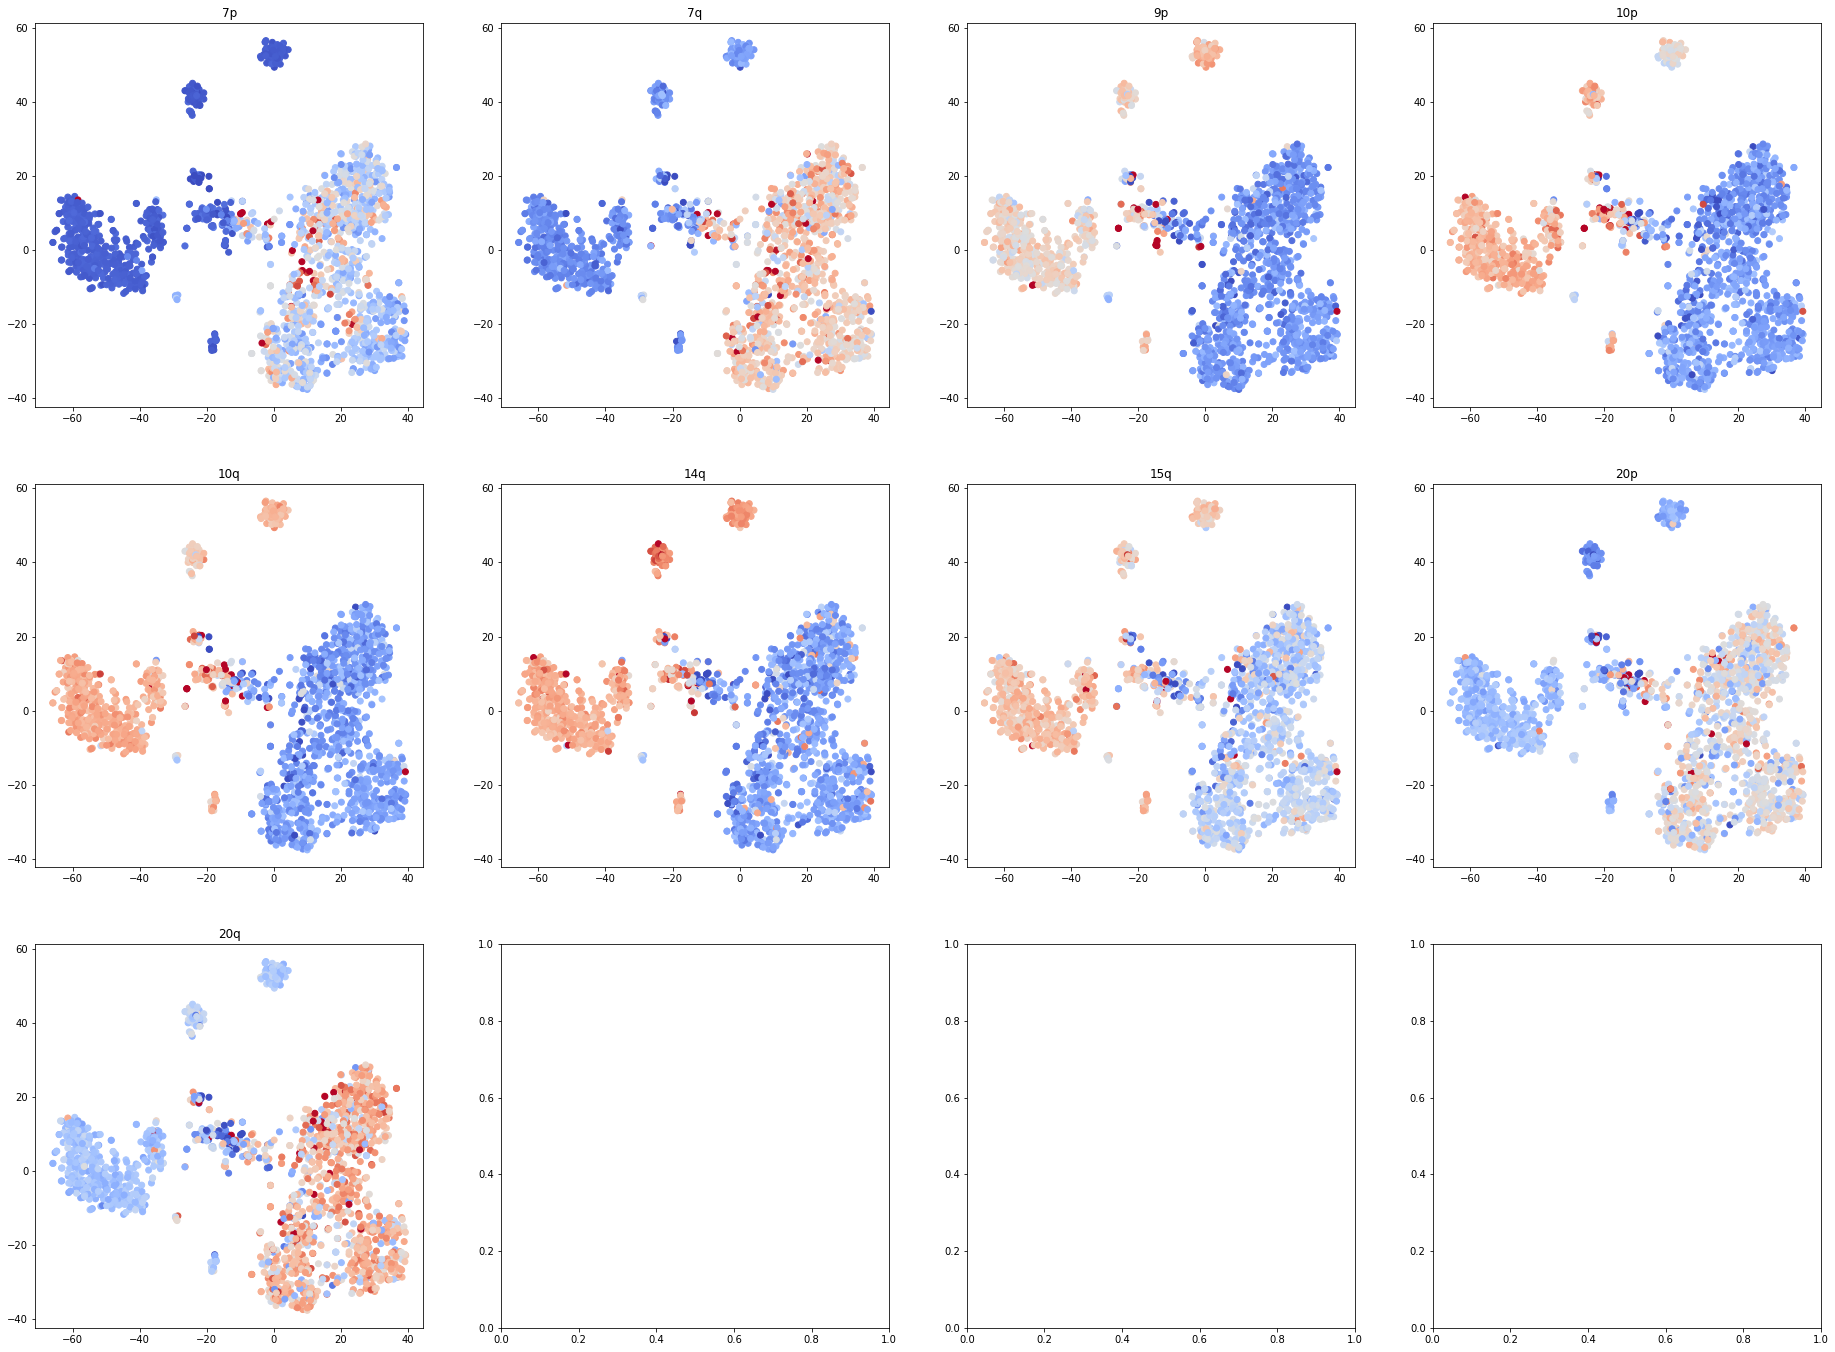

In [130]:
with loompy.connect(f_bins, 'r') as ds:
    nrows = int(np.ceil(len(bimodals)/4))
    fig, ax = plt.subplots(nrows, 4, figsize=(32,24))
    ax = ax.flatten()

    for i, x in enumerate(bimodals):
        im = ax[i].scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c=Z[x,:], vmax=np.quantile(Z[x,:], .99), vmin = np.quantile(Z[x,:], .01), cmap='coolwarm')
        ax[i].set_title(arms[x,0])

Getting labels
plotting


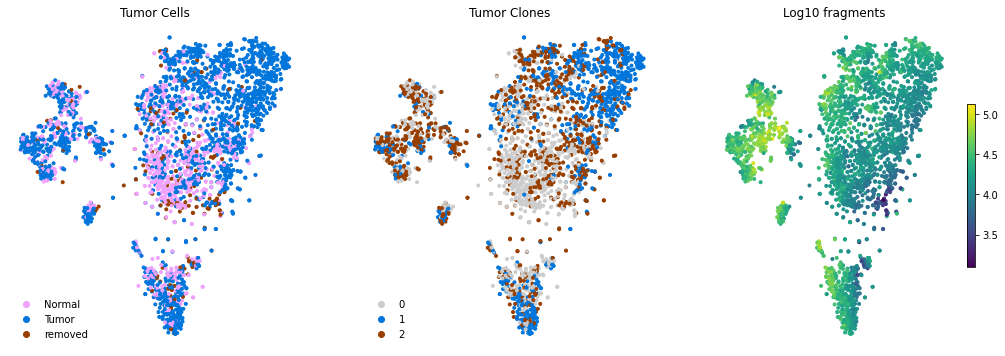

In [8]:
import pandas as pd
import loompy
import matplotlib.pyplot as plt
from cytograph.plotting.colors import colorize
import numpy as np

# f_bins = '/proj/DEV_ATAC/test/CNV/10X324_1_20kb.loom'
# f_copyscat = '/proj/DEV_ATAC/test/CNV/324_1_nmf_clusters.csv'
# f_normal = '/proj/DEV_ATAC/test/CNV/324_1_nmf_normal.csv'
f_bins = '/datb/sl/camiel/scATAC/samples/10X309_1/10X309_1_20kb.loom'
f_copyscat = '/datb/sl/camiel/scATAC/samples/10X309_1/10X309_1_nmf_clusters.csv'
f_normal = '/datb/sl/camiel/scATAC/samples/10X309_1/10X309_1_nmf_normal.csv'

clusters = pd.read_csv(f_copyscat)
cls = clusters['nmf_results.cellAssigns'].to_numpy()
normal = int(np.loadtxt(f_normal))
code = {normal: 'Normal'}
for k in np.unique(cls):
    if k != normal:
        code[k] = 'Tumor'

with loompy.connect(f_bins, 'r') as ds:
    print('Getting labels')
    neoplastic = []
    bars = clusters['Barcode'].to_numpy()
    cluster_labels = clusters['nmf_results.cellAssigns'].to_numpy()
    cnv_type = np.array([code[x] for x in cls])
    clones = []
    for x in ds.ca.barcode:
        if x in bars:
            cnv = cnv_type[clusters['Barcode'] == x][0]
            if cnv == 'Normal':
                neoplastic.append(cnv)
                clones.append(0)            
            else:
                neoplastic.append(cnv)
                clones.append(cluster_labels[clusters['Barcode'] == x][0])
        else:
            neoplastic.append('removed')
            clones.append(0)
    neoplastic = np.array(neoplastic)
    clones = np.array(clones)
    
    print('plotting')
    fig, ax = plt.subplots(1, 3, figsize=(18,6))
    names, labels = np.unique(neoplastic, return_inverse=True)
    colors = colorize(names)
    ax[0].scatter(ds.ca.TSNE[:,0],ds.ca.TSNE[:,1], c=colors[labels], marker='.')

    def h(c):
        return plt.Line2D([], [], color=c, ls="", marker="o")
    ax[0].legend(handles=[h(colors[i]) for i in range(len(names))], labels=list(names), loc='lower left', markerscale=1, frameon=False, fontsize=10)
    ax[0].set_title(f'Tumor Cells')
    ax[0].axis('off')
    
    names, labels = np.unique(clones, return_inverse=True)
    colors = colorize(names)
    colors[0,:] = [.8,.8,.8]
    ax[1].scatter(ds.ca.TSNE[:,0],ds.ca.TSNE[:,1], c=colors[labels], marker='.')
    ax[1].legend(handles=[h(colors[i]) for i in range(len(names))], labels=list(names), loc='lower left', markerscale=1, frameon=False, fontsize=10)
    ax[1].set_title(f'Tumor Clones')
    ax[1].axis('off')    
    
    im = ax[2].scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c=np.log10(ds.ca.passed_filters), marker='.')
    fig.colorbar(im, ax=ax[2], orientation='vertical', shrink=.5)
    ax[2].set_title('Log10 fragments')
    ax[2].axis('off')

In [6]:
import os
import glob
import numpy as np
import pandas as pd

import loompy
from chromograph.pipeline import config
import logging
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

class add_to_loom():
    def __init__(self, outdir):
        self.config = config.load_config()
        self.outdir = outdir
        self.f_copyscat = glob.glob(os.path.join(self.outdir, '*_nmf_clusters.csv'))[0]
        self.f_normal = glob.glob(os.path.join(self.outdir, '*_nmf_normal.csv'))[0]      
        self.f_plot = os.path.join(self.outdir, 'tumor_labels.png')
        
    def fit(self, ds):
        sample_ID = ds.filename.split('/')[-2]
        logging.info('Getting labels')
        clusters = pd.read_csv(self.f_copyscat)
        cls = clusters['nmf_results.cellAssigns'].to_numpy()
        normal = int(np.loadtxt(self.f_normal))
        code = {normal: 'Normal'}
        for k in np.unique(cls):
            if k != normal:
                code[k] = 'Tumor'
        
        neoplastic = []
        bars = clusters['Barcode'].to_numpy()
        cluster_labels = clusters['nmf_results.cellAssigns'].to_numpy()
        cnv_type = np.array([code[x] for x in cls])
        clones = []
        for x in ds.ca.barcode:
            if x in bars:
                cnv = cnv_type[clusters['Barcode'] == x][0]
                if cnv == 'Normal':
                    neoplastic.append(cnv)
                    clones.append(f'{sample_ID}_0')           
                else:
                    neoplastic.append(cnv)
                    clones.append(f'{sample_ID}_{cluster_labels[clusters["Barcode"] == x][0]}')
            else:
                neoplastic.append('removed')
                clones.append(f'{sample_ID}_0')
        ds.ca.neoplastic = np.array(neoplastic)
        ds.ca.clonal_id = np.array(clones)
        
        if not os.path.isfile(self.f_plot):
            logging.info('plotting')
            fig, ax = plt.subplots(1, 3, figsize=(18,6))
            names, labels = np.unique(ds.ca.neoplastic, return_inverse=True)
            colors = colorize(names)
            ax[0].scatter(ds.ca.TSNE[:,0],ds.ca.TSNE[:,1], c=colors[labels], marker='.')

            def h(c):
                return plt.Line2D([], [], color=c, ls="", marker="o")
            ax[0].legend(handles=[h(colors[i]) for i in range(len(names))], labels=list(names), loc='lower left', markerscale=1, frameon=False, fontsize=10)
            ax[0].set_title(f'Tumor Cells')
            ax[0].axis('off')

            names, labels = np.unique(ds.ca.clonal_id, return_inverse=True)
            colors = colorize(names)
            colors[0,:] = [.8,.8,.8]
            ax[1].scatter(ds.ca.TSNE[:,0],ds.ca.TSNE[:,1], c=colors[labels], marker='.')
            ax[1].legend(handles=[h(colors[i]) for i in range(len(names))], labels=list(names), loc='lower left', markerscale=1, frameon=False, fontsize=10)
            ax[1].set_title(f'Tumor Clones')
            ax[1].axis('off')    

            im = ax[2].scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c=np.log10(ds.ca.passed_filters), marker='.')
            fig.colorbar(im, ax=ax[2], orientation='vertical', shrink=.5)
            ax[2].set_title('Log10 fragments')
            ax[2].axis('off')

            plt.savefig(self.f_plot)

f_bins = '/proj/DEV_ATAC/test/CNV/10X324_1_20kb.loom'
with loompy.connect(f_bins, 'r+') as ds:
    ad = add_to_loom('/proj/DEV_ATAC/test/CNV/')
    ad.fit(ds)

14:18:30 INFO     Getting labels


In [2]:
os.listdir('/datb/sl/camiel/scATAC/samples/10X324_1/')

['10X324_1_1000kb.loom',
 'fragments',
 '10X324_1_20kb.loom',
 '10X324_1_5kb.loom',
 'counts.pkl',
 '10X324_1_prom.loom']

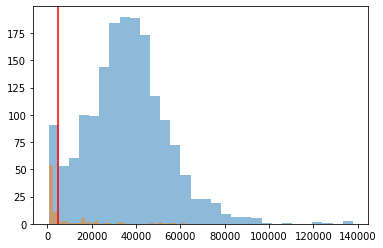

In [125]:
with loompy.connect(f_bins, 'r') as ds:    
    plt.hist(ds.ca.passed_filters, bins=30, alpha=.5)
    plt.hist(ds.ca.passed_filters[neoplastic=='removed'], bins=30, alpha=.5)
    plt.axvline(5000, c='red')

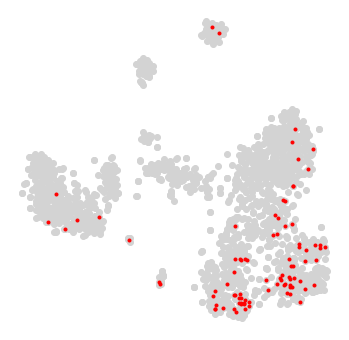

In [167]:
f_cycling = '/proj/DEV_ATAC/test/CNV/324_1_cycling_cells.tsv'
cycling = pd.read_csv(f_cycling, names=['Barcode', 'cycling'], delimiter='\t')
cycling = cycling[cycling['cycling']==True]['Barcode'].to_numpy()

with loompy.connect(f_bins, 'r') as ds:
    is_cycling = np.where(np.array([x in cycling for x in ds.ca.barcode]))[0]
    plt.figure(figsize=(6,6))
    plt.scatter(ds.ca.TSNE[:,0],ds.ca.TSNE[:,1], c='lightgrey')
    plt.scatter(ds.ca.TSNE[is_cycling,0],ds.ca.TSNE[is_cycling,1], c='red', marker='.')
    plt.axis('off')

In [155]:
def mergeBins(f, bin_size):
    with loompy.connect(f, 'r') as ds:
        ## Assume that original file has bin sizes of size 5kb
        factor = int(bin_size/5000)

        ## Retrieve dense matrix        
        data = ds[:,:].astype('int8')   
        new_data = []

        new_bins = {'chrom' : [], 'start': [], 'end': [], 'loc': []}
        sizes = []
        
        ## Loop over chromosomes to compact bins
        for i in np.unique(ds.ra.chrom):

            ## If no remainder from dividing N original bins by factor
            vals = data[ds.ra.chrom==i,:]
            if vals.shape[0]%factor == 0:
                X = rebin(vals, (int(vals.shape[0]/factor), vals.shape[1]))
            elif vals.shape[0] < factor:
                X = rebin(vals, (1, vals.shape[1])) ## Merge all bins
            else:
                rem = vals.shape[0]%factor
                X = rebin(vals[:-rem,:], (int(vals.shape[0]/factor), vals.shape[1]))
                X2 = rebin(vals[-rem:,:], (1, vals.shape[1])) ## Merge the last (or last few) bins to one bin
                X = np.vstack((X, X2))

            new_data.append(X.astype('int8'))

            for start, end in zip(ds.ra.start[ds.ra.chrom==i][::factor], ds.ra.end[ds.ra.chrom==i][(factor-1)::factor]):
                new_bins['chrom'].append(i)
                new_bins['start'].append(start)
                new_bins['end'].append(end)
                new_bins['loc'].append(f'{i}:{start}:{end}')

            ## If there was a remainder, name of last bin will be the added to the dictionary
            if len(ds.ra.end[ds.ra.chrom==i][(factor-1)::factor]) < X.shape[0]:
                start = str(int(new_bins['end'][-1]) + 1)
                end = np.max(ds.ra.end[ds.ra.chrom==i].astype('int'))
                new_bins['chrom'].append(i)
                new_bins['start'].append(start)
                new_bins['end'].append(end)
                new_bins['loc'].append(f'{i}:{start}:{end}')

        ## Make matrix sparse
        matrix = sparse.coo_matrix(np.vstack(new_data)).tocsr()
        
        ## Create loomfile
        sampleid = f.split('/')[-2] + '_' + str(int(bin_size/1000)) + 'kb'
        floom = os.path.join(os.path.dirname(f), sampleid + '.loom')
        
        for k in new_bins:
            new_bins[k] = np.array(new_bins[k])
        
        print(matrix.shape)
        print(new_bins['chrom'].shape)
        
        loompy.create(filename=floom, 
                      layers=matrix, 
                      row_attrs=new_bins, 
                      col_attrs=ds.ca,
                      file_attrs=ds.attrs)
        
        ## Change bin_size in attributes
        with loompy.connect(floom) as dsout:
            dsout.attrs['bin_size'] = bin_size
        
        logging.info(f"Loom-file with {str(int(bin_size/1000)) + 'kb'} bins saved as {floom}")

In [156]:
f_1mb = '/datb/sl/camiel/scATAC/samples/10X324_1/10X324_1_1000kb.loom'
mergeBins(f_bins, 1e6)

(3103, 1711)
(3103,)


14:59:50 INFO     Loom-file with 1000kb bins saved as /datb/sl/camiel/scATAC/samples/10X324_1/10X324_1_1000kb.loom


(3103, 1711)


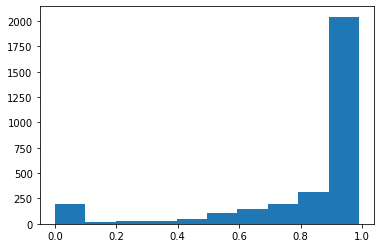

In [163]:
with loompy.connect(f_1mb, 'r') as ds:

    print(ds.shape)
    nnz = ds.map([np.count_nonzero], axis=0)[0] / ds.shape[1]
    
    plt.hist(nnz)

['Age', 'Agetext', 'Ageunit', 'All_fc_analysis_id', 'Analysis', 'CellID', 'Cellconc', 'Chemistry', 'Cmobarcodes', 'Comment', 'DNase_sensitive_region_fragments', 'Datecaptured', 'Donor', 'DoubletFinderFlag', 'DoubletFinderScore', 'Editat', 'Editby', 'Id', 'Label', 'Method', 'Name', 'Neuronprop', 'Numpooledanimals', 'PCA', 'Plugdate', 'Project', 'Roi', 'Sampleok', 'Sex', 'Shortname', 'Species', 'Strain', 'TSNE', 'TSS_fragments', 'Targetnumcells', 'Tissue', 'Transcriptome', 'barcode', 'blacklist_region_fragments', 'chimeric', 'clonal_id', 'duplicate', 'enhancer_region_fragments', 'excluded_reason', 'is__cell_barcode', 'lowmapq', 'mitochondrial', 'neoplastic', 'nonprimary', 'on_target_fragments', 'passed_filters', 'peak_region_cutsites', 'peak_region_fragments', 'promoter_region_fragments', 'total', 'unmapped']
904
14031
6021
0.3570835409400432
0.9895231986316014


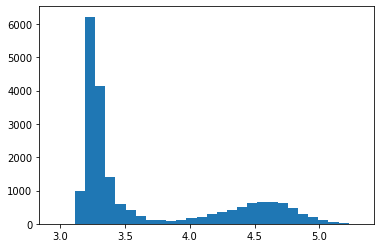

In [26]:
with loompy.connect('/datb/sl/camiel/scATAC/samples/10X328_1/10X328_1_5kb.loom') as ds:

    print(ds.ca.keys())
    plt.hist(np.log10(ds.ca.passed_filters), bins=30)
    print(np.sum(ds.ca.passed_filters<5000))
    print(np.sum(ds.ca.passed_filters>5000))
    print(np.sum((ds.ca.passed_filters>5000) & (ds.ca.DoubletFinderFlag==0)) / np.sum(ds.ca.passed_filters>5000))
    print(np.sum((ds.ca.passed_filters<5000) & (ds.ca.DoubletFinderFlag==0)) / np.sum(ds.ca.passed_filters<5000))

In [23]:
np.log10(5000)

3.6989700043360187